In [1]:
import numpy as np
from scipy.linalg import svd
import pickle
import matplotlib.pyplot as plt
from lib import read_file,bipartite_split

In [2]:
def level_spacing_spectrum(ent:np.ndarray) -> np.ndarray:
    """
    Calculates the level spacing ratio statistic of the schmidt values given in `ent`.
    The first dimension of `ent` runs over the realizations, the second
    one runs over the singular values at the bonds.
    """
    if False:
        # averaging over the singular values
        ent_avg = ent.mean(axis=0)

        # sorting the singular values in descending order
        ent_avg = ent_avg[np.argsort(ent_avg)][::-1]

        spacings = ent_avg[:-1] - ent_avg[1:]

        ratios = spacings[1:] / spacings[:-1]
        return ratios
    
    # sorting the singular values in descending order
    ent = np.take_along_axis(ent,np.argsort(ent,axis=1),axis=1)[:,::-1]
    
    spacings = ent[:,:-1] - ent[:,1:]
    ratios = (spacings[:,1:] / spacings[:,:-1]).flatten()

    # dropping overly large and small values
    ratios = ratios[np.logical_and(ratios > 1e-5,ratios < 1e5)]

    # dropping nan, inf
    ratios = ratios[np.isfinite(ratios)]

    return np.array(ratios)

In [3]:
# reading the data from the pickled file
therm_data = ()
beta_data = ()
gate_sets = ()

# thermalization for different gate sets
therm_data += read_file("data/07-02_19-40-49___data.pickle")
"""(CNOT,H,X)"""
therm_data += read_file("data/07-02_19-40-58___data.pickle")
"""(CNOT,H,S)"""
therm_data += read_file("data/07-02_19-41-03___data.pickle")
"""(CNOT,H,T)"""

# thermalization for different (inverse) temperatures beta
beta_data += read_file("data/07-02_19-44-30___data.pickle")

File data/07-02_19-40-49___data.pickle is over.
File data/07-02_19-40-58___data.pickle is over.
File data/07-02_19-41-03___data.pickle is over.
File data/07-02_19-44-30___data.pickle is over.


# bipartite split for every system after heating, yielding the singular values

In [4]:
singvals = {}

for dataset in therm_data:
    if dataset["gate_set"] not in singvals.keys(): singvals[dataset["gate_set"]] = {}
    
    # bipartite split
    dataset_singvals = bipartite_split(dataset["psi_heating"])
    singvals[dataset["gate_set"]][dataset["heating"]["nWires"]] = dataset_singvals

In [5]:
spacings = {}

for gate_set in singvals.keys():
    if gate_set not in spacings.keys(): spacings[gate_set] = {}

    for nWires in singvals[gate_set].keys():
        # sorting in descending order
        mask = np.argsort(singvals[gate_set][nWires],axis=1)
        singvals_ordered = np.take_along_axis(singvals[gate_set][nWires],mask,axis=1)[:,::-1]

        # calculating the spacings
        spacings[gate_set][nWires] = singvals_ordered[:,:-1] - singvals_ordered[:,1:]

In [6]:
ratios = {}

for gate_set in spacings.keys():
    if gate_set not in ratios.keys(): ratios[gate_set] = {}

    for nWires in spacings[gate_set].keys():
        # calculating the ratios
        ratios[gate_set][nWires] = (spacings[gate_set][nWires][:,1:] / spacings[gate_set][nWires][:,:-1]).flatten()

/var/folders/xd/w75n_hkn7yxdt_5lc6n52n0m0000gn/T/ipykernel_79020/3635844896.py:8: RuntimeWarning: divide by zero encountered in divide
  ratios[gate_set][nWires] = (spacings[gate_set][nWires][:,1:] / spacings[gate_set][nWires][:,:-1]).flatten()


In [7]:
print(ratios.keys())

dict_keys([('CNOT', 'H', 'X'), ('CNOT', 'H', 'S'), ('CNOT', 'H', 'T')])


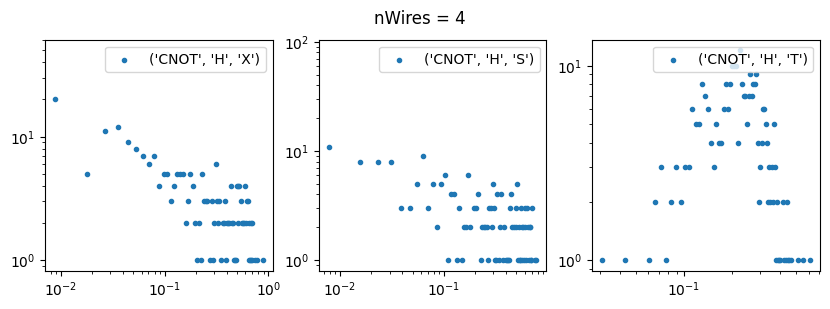

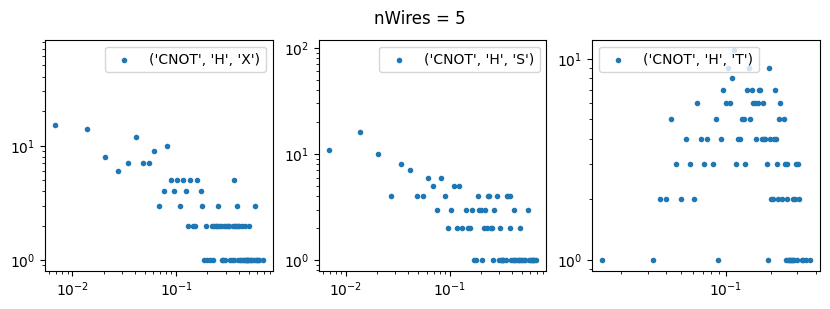

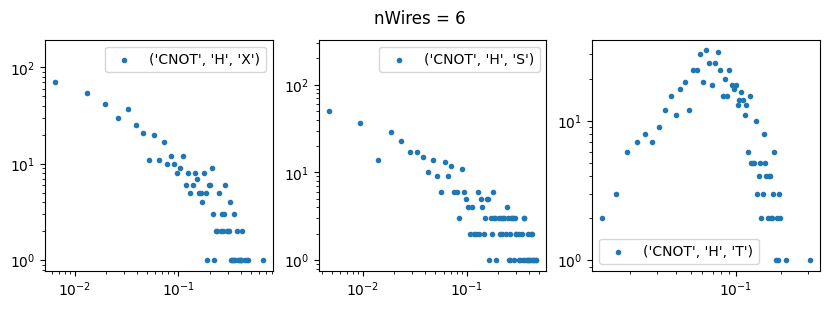

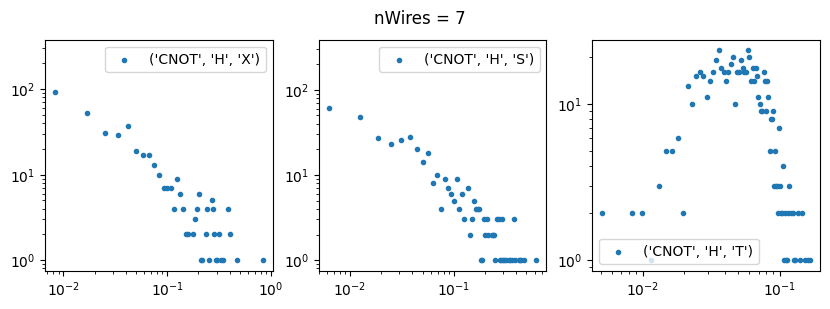

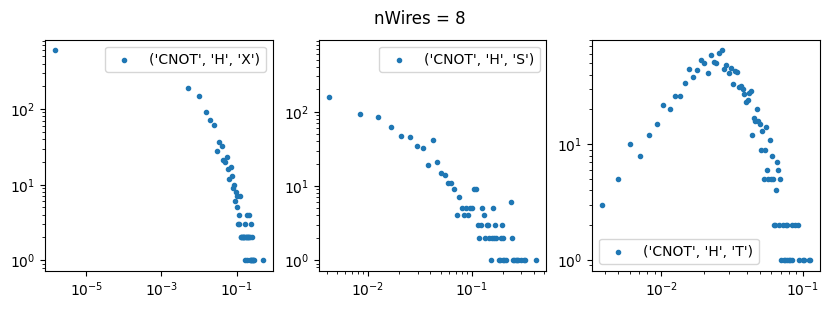

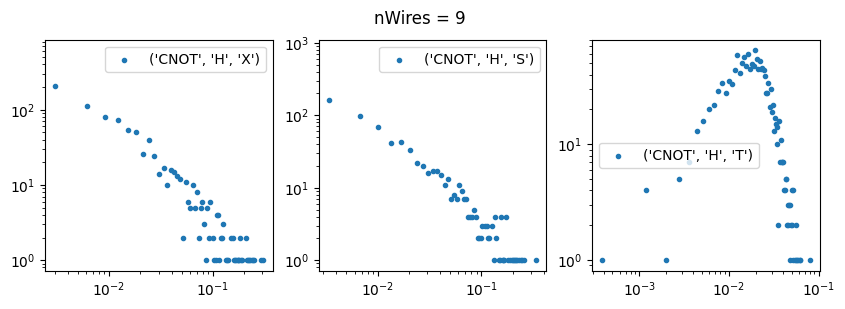

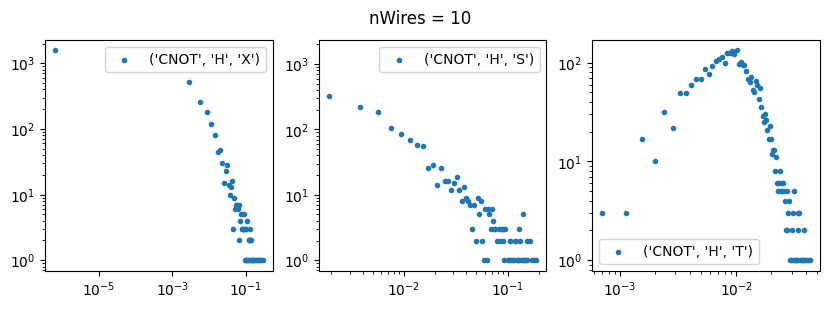

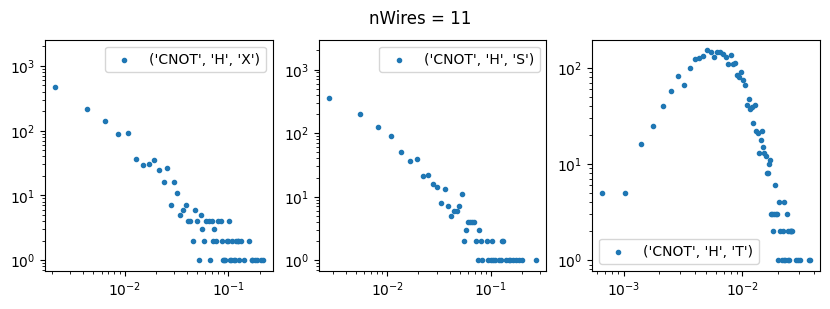

In [27]:
for nWires in ratios[('CNOT', 'H', 'X')].keys():
    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(10,3))
    for iGates,gate_set in enumerate(ratios.keys()):
        counts,bins = np.histogram(spacings[gate_set][nWires].flatten(),bins=100)
        ax[iGates].scatter(bins[0] / 2 + bins[:-1] ,counts,label=str(gate_set),marker=".")
        ax[iGates].legend()
        ax[iGates].set_xscale("log")
        ax[iGates].set_yscale("log")
    fig.suptitle("nWires = {}".format(nWires))